In [0]:
!pip install bayesian-optimization
!pip install scikit-optimize
!pip install shap

In [1]:
# train.csv and test.csv
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving test.csv to test.csv


In [0]:
import numpy as np 
import pandas as pd 
from scipy import stats as ss
import statsmodels.api as sm
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# May need manual installation, see cell above
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV
import shap

In [0]:
df_raw = pd.read_csv("train.csv")
test_df_raw = pd.read_csv("test.csv")

def get_day(x):
    return x.date()

def DaysBeforeCat(days):
    if days == 0:
        return '0 days'
    elif days in range(1,3):
        return '1-2 days'
    elif days in range(3,8):
        return '3-7 days'
    elif days in range(8, 32):
        return '8-31 days'
    else:
        return '> 31 days'

In [0]:
def getting_ready(df):
    
    df['pat_id'].astype('int64')
    #df.set_index('ReminderId', inplace = True)
    
    # Creating new variables
    #df['NoShow'] = (df['No-show'] == 'Yes')*1
    df['noshow'] = (df['response'] == 0)*1
    df['prev_app'] = df.sort_values(by = ['pat_id','apt_date']).groupby(['pat_id']).cumcount()
    df['prev_noshow'] = (df[df['prev_app'] > 0].sort_values(['pat_id', 'apt_date']).groupby(['pat_id'])['noshow'].cumsum() / df[df['prev_app'] > 0]['prev_app'])
    
    # TODO: compute prev_app, prev_noshow for fam_id as well
    df['prev_fam_app'] = df.sort_values(by = ['family_id','apt_date']).groupby(['family_id']).cumcount()
    df['prev_fam_noshow'] = (df[df['prev_app'] > 0].sort_values(['family_id', 'apt_date']).groupby(['family_id'])['noshow'].cumsum() / df[df['prev_app'] > 0]['prev_app'])

    df['apt_date'] = pd.to_datetime(df['apt_date'])
    df['apt_date_isweekday'] = df.apply(lambda x: x['apt_date'].isoweekday(), axis = 1)
    #df['HasHandicap'] = (df['Handcap'] > 0)*1
    #df['PreviousDisease'] = df.apply(lambda x: ((x.Hipertension == 1 )| x.Diabetes == 1 | x.Alcoholism == 1)*1, axis = 1)
    df['remind_date'] = pd.to_datetime(df['sent_time'])
    df['remind_date_isweekday'] = df.apply(lambda x: x['remind_date'].isoweekday(), axis = 1)
    df['remind_apt_gap'] = ((df['apt_date'].apply(get_day) - df['remind_date'].apply(get_day)).astype('timedelta64[D]')).astype(int)
    df['remind_notsent'] = (df['net_hour'] == -99999)*1
    df2 = df[(df['age'] >= 0)]
    
    return df2

df = getting_ready(df_raw)

In [0]:
def make_dummies(df_raw):
  df = df_raw.copy()
  df = df.assign(apt_onmonday = (df['apt_date_isweekday'] == 1)*1,
                    apt_ontuesday = (df['apt_date_isweekday'] == 2)*1,
                    apt_onwednesday = (df['apt_date_isweekday'] == 3)*1,
                    apt_onthursday = (df['apt_date_isweekday'] == 4)*1,
                    apt_onfriday = (df['apt_date_isweekday'] == 5)*1,
                    apt_onsaturday = (df['apt_date_isweekday'] == 6)*1,
                    apt_onsunday = (df['apt_date_isweekday'] == 7)*1)

  df = df.assign(remind_onmonday = (df['remind_date_isweekday'] == 1)*1,
                    remind_ontuesday = (df['remind_date_isweekday'] == 2)*1,
                    remind_onwednesday = (df['remind_date_isweekday'] == 3)*1,
                    remind_onthursday = (df['remind_date_isweekday'] == 4)*1,
                    remind_onfriday = (df['remind_date_isweekday'] == 5)*1,
                    remind_onsaturday = (df['remind_date_isweekday'] == 6)*1,
                    remind_onsunday = (df['remind_date_isweekday'] == 7)*1)

  df = df.assign(isfemale = (df['gender'] == 'F')*1)
  
  return df


In [0]:
features = ['apt_onmonday', 'apt_ontuesday', 'apt_onwednesday',
            'apt_onthursday', 'apt_onfriday', 'apt_onsaturday', 'apt_onsunday',
            'remind_onmonday', 'remind_ontuesday', 'remind_onwednesday',
            'remind_onthursday', 'remind_onfriday', 'remind_onsaturday', 'remind_onsunday',
            'net_hour', 'remind_notsent', 'fam',
            'isfemale', 'age', 'dist', 
            'prev_app', 'prev_noshow', 'prev_fam_app', 'prev_fam_noshow'
           ]

label = 'response'

In [0]:
# Special thanks to https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
df_reduce = reduce_mem_usage(df)

X_train, X_test, y_train, y_test = train_test_split(df_reduce[features], df_reduce[label], test_size=0.3, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

Mem. usage decreased to 138.57 Mb (58.0% reduction)


# Naive XGBoost model

In [0]:
def param_opt_xgb(X, y, init_round=10, opt_round=10, n_folds=3, random_seed=6, output_process=False):
    # Prepare data
    dtest = xgb.DMatrix(X, y)

    def xgb_eval(learning_rate, n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, scale_pos_weight):
        params = {'objective' : 'binary:logistic', 'nthread' : 4, 'seed' : random_seed, "silent":1}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params['n_estimators'] = int(round(n_estimators))
        params['max_depth'] = int(round(max_depth))
        params['min_child_weight'] = int(round(min_child_weight))
        params['gamma'] = gamma
        params['subsample'] = max(min(subsample, 1), 0)
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['scale_pos_weight'] = int(round(scale_pos_weight))

        cv_result = xgb.cv(params, dtest, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        
        
        return max(cv_result['train-auc-mean'])
    
    xgbBO = BayesianOptimization(xgb_eval, {'learning_rate': (0.01, 0.3),
                                                'n_estimators': (100, 200),
                                                'max_depth': (2, 7),
                                                'min_child_weight': (0, 7),
                                                'gamma': (0, 0.3),
                                                'subsample':(0.5,1),
                                                'colsample_bytree': (0.5, 1),
                                                'scale_pos_weight':(2,7)}, random_state=random_seed)

    xgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_aucpr=[]
    for model in range(len(xgbBO.res)):
        model_aucpr.append(xgbBO.res[model]['target'])

    # return best parameters
    return xgbBO.res[pd.Series(model_aucpr).idxmax()]['target'],xgbBO.res[pd.Series(model_aucpr).idxmax()]['params']

In [16]:
opt_params = param_opt_xgb(df_reduce[features], df_reduce[label])


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
[0]	train-auc:0.808028+0.0082208	test-auc:0.807991+0.008407
[9]	train-auc:0.835716+0.000556058	test-auc:0.835753+0.000798955
|  1        |  0.8357   |  0.9464   |  0.09959  |  0.2482   |  2.208    |  0.7536   |  159.5    |  4.649    |  0.7094   |
[0]	train-auc:0.834319+0.0113625	test-auc:0.834322+0.0120375
[9]	train-auc:0.849801+0.00111299	test-auc:0.849466+0.00109394
|  2        |  0.8498   |  0.6677   |  0.1868   |  0.1371   |  5.679    |  3.626    |  157.9    |  5.227    |  0.9951   |
[0]	train-auc:0.833951+0.0104518	test-auc:0.833871+0.0108652
[9]	train-auc:0.852313+0.000458579	test-auc:0.852107+0.000419242
|  3        |  0.8523   |  0.9099   |  0.124    |  0.2641   |  6.119    |  0.3813   |  171.9    |  6.011    |  0.8682   |
[0]	train-auc:0

In [17]:
opt_params[1]['n_estimators'] = int(round(opt_params[1]['n_estimators']))
opt_params[1]['max_depth'] = int(round(opt_params[1]['max_depth']))
opt_params[1]['min_child_weight'] = int(round(opt_params[1]['min_child_weight']))
opt_params[1]['scale_pos_weight'] = int(round(opt_params[1]['scale_pos_weight']))
opt_params[1]['objective']='binary:logistic'
opt_params[1]['metric']='auc'
opt_params[1]['nthread']=4
opt_params[1]['seed']=6
opt_params=opt_params[1]
opt_params

{'colsample_bytree': 0.5274980506711665,
 'gamma': 0.19241796128004063,
 'learning_rate': 0.2182016318228694,
 'max_depth': 7,
 'metric': 'auc',
 'min_child_weight': 7,
 'n_estimators': 139,
 'nthread': 4,
 'objective': 'binary:logistic',
 'scale_pos_weight': 2,
 'seed': 6,
 'subsample': 0.8434933713324515}

In [0]:
def modelfit(alg, dtrain, dtest, predictors, target, eval_metric = True):
        #Fit the algorithm on the data
        if eval_metric:
            alg.fit(dtrain[predictors], dtrain[target].values.ravel(), eval_metric = ['auc'])
        else: 
            alg.fit(dtrain[predictors], dtrain[target].values.ravel())
            
        #Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
        #Predict test set:
        dtest_predictions = alg.predict(dtest[predictors])
        dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
            
        #Print model report:
        print( " Model Report")
        print("Accuracy Train: %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
        print("Recall Train: %.4g" % metrics.recall_score(dtrain[target].values, dtrain_predictions))
        print("Accuracy Test: %.4g" % metrics.accuracy_score(dtest[target].values, dtest_predictions))
        print("Recall Test: %.4g" % metrics.recall_score(dtest[target].values, dtest_predictions))
        print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

In [19]:
xgb1 = XGBClassifier(
        learning_rate =opt_params['learning_rate'],
        n_estimators=opt_params['n_estimators'],
        max_depth=6,
        min_child_weight=opt_params['min_child_weight'],
        gamma=opt_params['gamma'],
        subsample=opt_params['subsample'],
        colsample_bytree=opt_params['colsample_bytree'],
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=opt_params['scale_pos_weight'],
        seed=6)

modelfit(xgb1, train, test, features, target = label)

 Model Report
Accuracy Train: 0.7558
Recall Train: 0.9889
Accuracy Test: 0.7554
Recall Test: 0.9871
AUC Score (Train): 0.863646


In [20]:
print('Accuracy naive model: {:1.4f}'.format(1-test[label].mean()))


Accuracy naive model: 0.4677


# Logistic regression model

In [0]:
df.columns

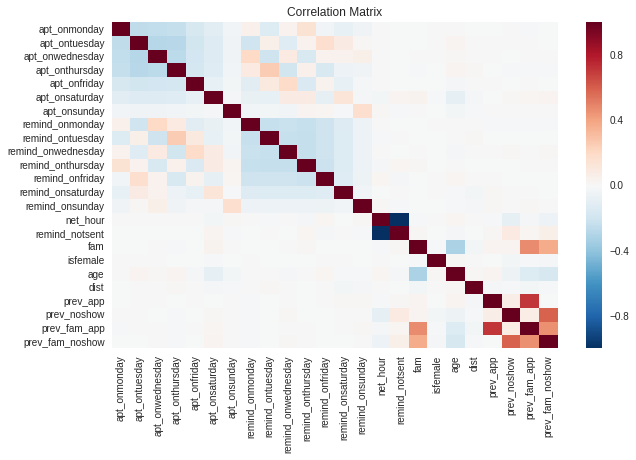

,apt_onmonday,apt_ontuesday,apt_onwednesday,apt_onthursday,apt_onfriday,apt_onsaturday,apt_onsunday,remind_onmonday,remind_ontuesday,remind_onwednesday,...,net_hour,remind_notsent,fam,isfemale,age,dist,prev_app,prev_noshow,prev_fam_app,prev_fam_noshow
apt_onmonday,1.000000,-0.253081,-0.247337,-0.235303,-0.164707,-0.112528,-0.034931,0.053352,-0.139555,0.043095,...,0.001907,-0.002051,-0.005690,0.005727,0.000845,-0.001965,-0.006155,0.003140,-0.008353,-0.000826
apt_ontuesday,-0.253081,1.000000,-0.287767,-0.273766,-0.191630,-0.130922,-0.040641,-0.200705,0.061560,-0.124193,...,0.000983,-0.001139,-0.004012,0.005139,0.026871,0.003668,0.006094,0.005277,0.000995,-0.001466
apt_onwednesday,-0.247337,-0.287767,1.000000,-0.267552,-0.187280,-0.127951,-0.039719,0.197538,-0.204757,0.090112,...,0.004275,-0.004366,0.004708,0.003816,0.015499,0.000938,0.000363,-0.001482,0.001374,0.000710
apt_onthursday,-0.235303,-0.273766,-0.267552,1.000000,-0.178168,-0.121725,-0.037786,0.093043,0.255269,-0.192430,...,0.003615,-0.003459,-0.009765,-0.000668,0.025703,0.008442,-0.005966,-0.010837,-0.009962,-0.012207
apt_onfriday,-0.164707,-0.191630,-0.187280,-0.178168,1.000000,-0.085205,-0.026450,-0.113649,0.098882,0.189703,...,0.005630,-0.005437,-0.004869,-0.006893,-0.017917,0.005140,0.005311,-0.003573,0.003634,-0.002197
apt_onsaturday,-0.112528,-0.130922,-0.127951,-0.121725,-0.085205,1.000000,-0.018070,-0.076403,-0.084302,0.080812,...,-0.029528,0.029675,0.031847,-0.012959,-0.089451,-0.023358,-0.000314,0.009458,0.020303,0.025106
apt_onsunday,-0.034931,-0.040641,-0.039719,-0.037786,-0.026450,-0.018070,1.000000,-0.031929,-0.027922,-0.031536,...,0.008044,-0.008020,0.001446,-0.007249,-0.031138,-0.011498,0.006125,0.006774,0.006042,0.006848
remind_onmonday,0.053352,-0.200705,0.197538,0.093043,-0.113649,-0.076403,-0.031929,1.000000,-0.228218,-0.226250,...,0.005382,-0.005417,-0.006570,0.003146,0.005830,0.005534,-0.008117,-0.009820,-0.010353,-0.008165
remind_ontuesday,-0.139555,0.061560,-0.204757,0.255269,0.098882,-0.084302,-0.027922,-0.228218,1.000000,-0.231531,...,-0.007993,0.007643,-0.000606,-0.001364,0.003289,0.008066,-0.001283,-0.001592,-0.002029,-0.001837
remind_onwednesday,0.043095,-0.124193,0.090112,-0.192430,0.189703,0.080812,-0.031536,-0.226250,-0.231531,1.000000,...,0.001196,-0.001764,0.006479,-0.004270,-0.018601,0.002258,0.001744,0.011816,0.006862,0.012580


In [23]:
# features0 = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
#        'Alcoholism', 'SMS_received','PreviousApp', 'PreviousNoShow', 'WeekdayScheduled', 'HasHandicap',
#        'PreviousDisease', 'WeekdayAppointment', 'DaysBeforeApp',
#        'DaysBeforeCat']
features0 = features
corr = df_reduce[features0].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Correlation Matrix')
plt.gcf().set_size_inches(10, 6)
plt.show()

corr

In [55]:
df_done = df_reduce

# Get rid of NaNs for logistic regression

df_done.loc[:, 'missed_app'] = df_done.sort_values(['apt_date']).groupby(['pat_id'])['response'].cumsum()
df_done.loc[:, 'missed_app_fam'] = df_done.sort_values(['apt_date']).groupby(['family_id'])['response'].cumsum()

features2 = ['apt_onmonday', 'apt_ontuesday', 'apt_onwednesday',
            'apt_onthursday', 'apt_onfriday', 'apt_onsaturday', 'apt_onsunday',
            'remind_onmonday', 'remind_ontuesday', 'remind_onwednesday',
            'remind_onthursday', 'remind_onfriday', 'remind_onsaturday', 'remind_onsunday',
            'net_hour', 'remind_notsent', 'fam',
            'isfemale', 'age', 'dist', 
            'missed_app', 'missed_app_fam'
           ]

scaler = StandardScaler().fit(df_done[features2])
df_rescaled = scaler.transform(df_done[features2])

X_train, X_test, y_train, y_test = train_test_split(df_done[features2], df_done[label], test_size=0.7, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, float16, int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int8, float16, int32 were all converted to float64 by StandardScaler.


In [56]:
logit = LogisticRegression(class_weight = 'balanced', solver = 'liblinear')
modelfit(logit, train, test, features2, label, eval_metric = False)

 Model Report
Accuracy Train: 0.8071
Recall Train: 0.8989
Accuracy Test: 0.8079
Recall Test: 0.8996
AUC Score (Train): 0.838686


In [57]:
tree = DecisionTreeClassifier(max_depth=12, random_state=0)
modelfit(tree, train, test,features2, label, eval_metric=False)

 Model Report
Accuracy Train: 0.842
Recall Train: 0.9971
Accuracy Test: 0.8396
Recall Test: 0.9936
AUC Score (Train): 0.860099


In [58]:
rf = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
modelfit(rf, train, test,features2, label, eval_metric=False)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Model Report
Accuracy Train: 0.9658
Recall Train: 0.9728
Accuracy Test: 0.7745
Recall Test: 0.8126
AUC Score (Train): 0.995871


In [0]:
preds = rf.predict(X_test)

In [50]:
preds

array([1, 0, 0, ..., 1, 1, 1], dtype=int8)

In [54]:
print(test_df_raw.columns)
print(features)
print(features2)

Index(['ReminderId', 'apt_type', 'apt_date', 'sent_time', 'send_time',
       'net_hour', 'type', 'clinic', 'city', 'province', 'cli_zip', 'cli_area',
       'cli_size', 'pat_id', 'family_id', 'fam', 'gender', 'age', 'pat_area',
       'dist'],
      dtype='object')
['apt_onmonday', 'apt_ontuesday', 'apt_onwednesday', 'apt_onthursday', 'apt_onfriday', 'apt_onsaturday', 'apt_onsunday', 'remind_onmonday', 'remind_ontuesday', 'remind_onwednesday', 'remind_onthursday', 'remind_onfriday', 'remind_onsaturday', 'remind_onsunday', 'net_hour', 'remind_notsent', 'fam', 'isfemale', 'age', 'dist', 'prev_app', 'prev_noshow', 'prev_fam_app', 'prev_fam_noshow']
['apt_onmonday', 'apt_ontuesday', 'apt_onwednesday', 'apt_onthursday', 'apt_onfriday', 'apt_onsaturday', 'apt_onsunday', 'remind_onmonday', 'remind_ontuesday', 'remind_onwednesday', 'remind_onthursday', 'remind_onfriday', 'remind_onsaturday', 'remind_onsunday', 'net_hour', 'remind_notsent', 'fam', 'isfemale', 'age', 'dist', 'missed_app', 'miss

In [0]:
def getting_test_ready(test_df_raw):
    test_df_raw.head()
    test_df = test_df_raw.copy()
    
    test_df['pat_id'].astype('int64')
    #test_df.set_index('ReminderId', inplace = True)
    
    # Creating new variables
    #df['NoShow'] = (df['No-show'] == 'Yes')*1
    #df['noshow'] = (df['response'] == 0)*1
    
    # Features that are in the train dataset 
    pat_features = ['pat_id', 'prev_app', 'prev_noshow', 'missed_app']
    fam_features = ['family_id', 'prev_fam_app', 'prev_fam_noshow', 'missed_app_fam']
    
    df_pat_subset = df_done[pat_features]
    df_pat_subset = df_pat_subset.groupby('pat_id', as_index=False).agg({'prev_app': 'max', 'prev_noshow': 'max', 'missed_app': 'max'})
    df_fam_subset = df_done[fam_features]
    df_fam_subset = df_fam_subset.groupby('family_id', as_index=False).agg({'prev_fam_app': 'max', 'prev_fam_noshow': 'max', 'missed_app_fam': 'max'})

    print("Merging patient quals")
    test_df = test_df.merge(df_pat_subset, on='pat_id', how='left')
    
    print("merging family quals")
    test_df = test_df.merge(df_fam_subset, on='family_id', how='left')

    fillna_features = ['prev_app', 'prev_fam_app', 'missed_app', 'missed_app_fam']
    
    for feat in fillna_features:
      test_df[feat].fillna(0, inplace=True)
    
    df = test_df
    
    print('Doing the transforms ')
    df['apt_date'] = pd.to_datetime(df['apt_date'])
    df['apt_date_isweekday'] = df.apply(lambda x: x['apt_date'].isoweekday(), axis = 1)
    #df['HasHandicap'] = (df['Handcap'] > 0)*1
    #df['PreviousDisease'] = df.apply(lambda x: ((x.Hipertension == 1 )| x.Diabetes == 1 | x.Alcoholism == 1)*1, axis = 1)
    df['remind_date'] = pd.to_datetime(df['sent_time'])
    df['remind_date_isweekday'] = df.apply(lambda x: x['remind_date'].isoweekday(), axis = 1)
    df['remind_apt_gap'] = ((df['apt_date'].apply(get_day) - df['remind_date'].apply(get_day)).astype('timedelta64[D]')).astype(int)
    df['remind_notsent'] = (df['net_hour'] == -99999)*1
    df2 = df[(df['age'] >= 0)]
    
    return df2


In [135]:
# pat_features = ['pat_id', 'prev_app', 'prev_noshow', 'missed_app']
# fam_features = ['family_id', 'prev_fam_app', 'prev_fam_noshow', 'missed_app_fam']

# pats = df_done[pat_features]
# pats = pats.groupby('pat_id', as_index=False).agg({'prev_app': 'max', 'prev_noshow': 'max', 'missed_app': 'max'})

test_df = getting_test_ready(test_df_raw)


Merging patient quals
merging family quals
Doing the transforms 


In [0]:
test_df = make_dummies(test_df)
test_df[label] = 0

In [136]:
test_df.head()

,ReminderId,apt_type,apt_date,sent_time,send_time,net_hour,type,clinic,city,province,...,prev_noshow,missed_app,prev_fam_app,prev_fam_noshow,missed_app_fam,apt_date_isweekday,remind_date,remind_date_isweekday,remind_apt_gap,remind_notsent
0,0,hygiene,2017-11-06 10:20:00,2017-10-30 11:00,11:00:00,-168,SMS,20089,Lloydminster,AB,...,0.0,1.0,6.0,2.0,2.0,1,2017-10-30 11:00:00,1,7,0
1,1,general,2019-01-25 10:00:00,2019-01-23 9:02,9:00:00,-48,SMS,122636,Barrie,ON,...,0.0,2.0,1.0,0.0,2.0,5,2019-01-23 09:02:00,3,2,0
2,2,general,2017-04-21 18:30:00,2017-04-15 11:00,11:00:00,-168,SMS,121164,Burnaby,BC,...,1.0,2.0,4.0,1.0,2.0,5,2017-04-15 11:00:00,6,6,0
3,3,general,2019-02-11 15:00:00,2019-02-06 18:03,18:00:00,-72,Email,122333,Ottawa,ON,...,NaN,0.0,0.0,NaN,0.0,1,2019-02-06 18:03:00,3,5,0
4,4,9r,2017-05-04 16:00:00,2017-04-27 8:03,8:00:00,-168,Email,20586,Victoria,BC,...,1.0,2.0,4.0,1.0,2.0,4,2017-04-27 08:03:00,4,7,0


In [137]:
test_df.describe()

,ReminderId,net_hour,clinic,cli_size,pat_id,family_id,fam,age,dist,prev_app,prev_noshow,missed_app,prev_fam_app,prev_fam_noshow,missed_app_fam,apt_date_isweekday,remind_date_isweekday,remind_apt_gap,remind_notsent
count,18689.000000,18689.000000,18689.000000,18689.000000,18689.000000,18689.000000,18689.000000,18689.000000,18689.000000,18689.000000,9283.000000,18689.000000,18689.000000,11852.000000,18689.000000,18689.000000,18689.000000,18689.000000,18689.000000
mean,9344.000000,-1337.253251,105855.514741,1454.975280,180379.491359,127622.028145,1.694687,45.926481,10.828474,1.442881,0.630859,1.038311,3.139333,1.238281,1.884156,3.028787,3.230135,6.872064,0.012200
std,5395.193926,10965.383257,40794.393889,1077.429698,120793.172325,90011.346238,0.985660,20.665088,21.181840,2.218497,0.429443,1.313795,4.095233,1.630859,2.178199,1.461999,1.602672,15.682871,0.109779
min,0.000000,-99999.000000,4.000000,19.000000,14.000000,14.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,4672.000000,-168.000000,121152.000000,674.000000,75271.000000,49381.000000,1.000000,30.000000,1.776000,0.000000,0.000000,0.000000,0.000000,0.308167,0.000000,2.000000,2.000000,3.000000,0.000000
50%,9344.000000,-72.000000,121881.000000,1202.000000,164652.000000,112825.000000,1.000000,50.000000,4.235000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,3.000000,4.000000,0.000000
75%,14016.000000,-48.000000,122523.000000,1956.000000,276361.000000,195031.000000,2.000000,60.000000,10.196000,2.000000,1.000000,2.000000,4.000000,1.000000,3.000000,4.000000,4.000000,7.000000,0.000000
max,18688.000000,-1.000000,143871.000000,4735.000000,435005.000000,330190.000000,6.000000,100.000000,247.331000,27.000000,1.000000,19.000000,40.000000,24.000000,24.000000,7.000000,7.000000,296.000000,1.000000


In [0]:
X_train, X_test, y_train, y_test = train_test_split(test_df[features2], test_df[label], test_size=1, random_state=6)
y_train = pd.DataFrame(y_train)
train = X_train.merge(y_train, left_index = True, right_index = True)
y_test = pd.DataFrame(y_test)
test = X_test.merge(y_test, left_index = True, right_index = True)

preds = rf.predict(X_test)

In [0]:
preds = tree.predict(test_df[features2])
test_df['response'] = preds
test_df.head()
output_df = test_df[['ReminderId', 'response']]
output_df.set_index('ReminderId', inplace=True)
RESULT_NAME = 'results.csv'
output_df.to_csv(RESULT_NAME)
files.download(RESULT_NAME)

In [152]:
preds

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [0]:
test_df['response'] = preds

In [155]:
test_df.head()

,ReminderId,apt_type,apt_date,sent_time,send_time,net_hour,type,clinic,city,province,...,apt_onsunday,remind_onmonday,remind_ontuesday,remind_onwednesday,remind_onthursday,remind_onfriday,remind_onsaturday,remind_onsunday,isfemale,response
0,0,hygiene,2017-11-06 10:20:00,2017-10-30 11:00,11:00:00,-168,SMS,20089,Lloydminster,AB,...,0,1,0,0,0,0,0,0,0,1
1,1,general,2019-01-25 10:00:00,2019-01-23 9:02,9:00:00,-48,SMS,122636,Barrie,ON,...,0,0,0,1,0,0,0,0,0,1
2,2,general,2017-04-21 18:30:00,2017-04-15 11:00,11:00:00,-168,SMS,121164,Burnaby,BC,...,0,0,0,0,0,0,1,0,1,1
3,3,general,2019-02-11 15:00:00,2019-02-06 18:03,18:00:00,-72,Email,122333,Ottawa,ON,...,0,0,0,1,0,0,0,0,0,0
4,4,9r,2017-05-04 16:00:00,2017-04-27 8:03,8:00:00,-168,Email,20586,Victoria,BC,...,0,0,0,0,1,0,0,0,1,1


In [0]:
output_df = test_df[['ReminderId', 'response']]

In [157]:
output_df.head()

RESULT_NAME = 'results.csv'


,ReminderId,response
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1


In [0]:
files.download(RESULT_NAME)